# **Annotated Normalizing Flows Tutorial for 1D Data Modeling**

In this notebook, we build a Normalizing Flow model to learn and generate a complex 1D distribution. The goal is to transform a simple base distribution (such as a uniform distribution) into the target distribution using a series of invertible, parameterized transformations.

---



## **1. Introduction**

Normalizing Flows are a class of generative models that learn an invertible transformation between a simple base distribution $p_Z(z)$ (usually Gaussian or uniform) and a complex data distribution $p_X(x)$. By leveraging the change-of-variables formula, the model computes the exact likelihood of the data:
$$
\log p_X(x) = \log p_Z(f(x)) + \log \left|\det \frac{\partial f(x)}{\partial x}\right|
$$
where $f$ is an invertible mapping and the second term is the log-determinant of the Jacobian of the transformation. Training is performed via maximum likelihood, and once the model is trained, sampling is achieved by drawing from $p_Z(z)$ and applying the inverse transformation $f^{-1}$.

In this notebook we:
- Generate our target 1D data.
- Define a piecewise linear flow layer that implements a simple invertible transformation.
- Compose multiple flow layers to form a flexible transformation.
- Train the model using maximum likelihood.
- Generate new samples by applying the inverse transformation to noise drawn from the base distribution.

---

## **3. Implementation**

Below we implement the complete pipiline in PyTorch


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, moyal, wasserstein_distance


### **3.1 Data Generation and Preprocessing**
We begin by generating our target distribution. The data is produced by multiplying samples from a uniform distribution with samples drawn from a Moyal (or Landau) distribution. For training, we filter the data to focus on the region of interest.

In [38]:
# Data generation parameters
size = 1000000
#np.random.seed(42)

# Generate data samples
random_pt = uniform(loc=2, scale=1).rvs(size=size, random_state=42)
random_smearing = moyal(loc=1, scale=0.2).rvs(size=size, random_state=42)
smeared_pt = np.multiply(random_pt, random_smearing)

# Filter to keep values in the desired range (e.g., [0,10])
data = smeared_pt.astype(np.float32)
data = data[(data >= 0) & (data <= 10)]
data = data[:100000] # Use a subset for training


In [39]:

# Normalizing the dataset in the intervall [0,1]
data_min = data.min()
data_max = data.max()
print(f"data_min = {data_min:.3f}, data_max = {data_max:.3f}")

data_norm = (data - data_min) / (data_max - data_min)

# Conversione in tensore PyTorch
data_tensor = torch.from_numpy(data_norm)


data_min = 0.984, data_max = 9.960


### **3.2 Defining the Normalizing Flow Architecture**

We implement a flow layer using a piecewise linear transformation. This layer divides the input space into segments (bins) and applies a linear transformation within each bin. The parameters of the transformation (widths and heights) are learned via backpropagation. We also define the inverse mapping and compute the log-determinant of the Jacobian for likelihood evaluation.


In [40]:
# =============================================================================
# 2. Definizione della Trasformazione Piecewise Linear
# =============================================================================
# Ora il dominio d'interesse per il flow è [0,1]
class PiecewiseLinearFlow(nn.Module):
    def __init__(self, num_bins=20, left=0.0, right=1.0, bottom=-3.0, top=3.0):
        super(PiecewiseLinearFlow, self).__init__()
        self.num_bins = num_bins
        self.left = left
        self.right = right
        self.bottom = bottom
        self.top = top
        # Inizializzo i parametri in modo "neutro":
        # Softmax(0) restituisce 1/num_bins, ovvero una suddivisione uniforme.
        self.unnormalized_widths = nn.Parameter(torch.zeros(num_bins))
        # Inizializza le heights per ottenere una mappatura lineare iniziale:
        initial_height = np.log((top - bottom) / num_bins)
        self.unnormalized_heights = nn.Parameter(torch.ones(num_bins) * initial_height)
    
    def get_knots(self):
        widths = F.softmax(self.unnormalized_widths, dim=0) * (self.right - self.left)
        heights = F.softmax(self.unnormalized_heights, dim=0) * (self.top - self.bottom)
        x_knots = torch.cumsum(widths, dim=0) + self.left
        x_knots = torch.cat([torch.tensor([self.left], device=x_knots.device), x_knots], dim=0)
        y_knots = torch.cumsum(heights, dim=0) + self.bottom
        y_knots = torch.cat([torch.tensor([self.bottom], device=y_knots.device), y_knots], dim=0)
        return x_knots, y_knots, widths, heights

    def forward(self, x):
        x_knots, y_knots, widths, heights = self.get_knots()
        slopes = heights / widths
        device = x.device
        x_knots = x_knots.to(device)
        y_knots = y_knots.to(device)
        slopes = slopes.to(device)
        
        # Per ogni x, trovo in quale intervallo [x_k, x_k+1] cade
        bin_idx = torch.searchsorted(x_knots, x, right=True) - 1
        bin_idx = torch.clamp(bin_idx, 0, self.num_bins - 1)
        
        y = torch.empty_like(x)
        log_det = torch.empty_like(x)
        
        # Maschere: x in [left, right], x < left, x > right
        in_mask = (x >= self.left) & (x <= self.right)
        left_mask = x < self.left
        right_mask = x > self.right
        
        if in_mask.any():
            x_in = x[in_mask]
            idx = bin_idx[in_mask]
            x_k = x_knots[idx]
            y_k = y_knots[idx]
            width = widths[idx]
            height = heights[idx]
            slope = slopes[idx]
            theta = (x_in - x_k) / width
            y_in = y_k + theta * height
            y[in_mask] = y_in
            log_det[in_mask] = torch.log(slope)
        
        if left_mask.any():
            slope_left = slopes[0]
            y0 = y_knots[0]
            x0 = self.left
            x_left = x[left_mask]
            y[left_mask] = y0 + slope_left * (x_left - x0)
            log_det[left_mask] = torch.log(slope_left).expand_as(x_left)
        
        if right_mask.any():
            slope_right = slopes[-1]
            y_end = y_knots[-1]
            x_end = self.right
            x_right = x[right_mask]
            y[right_mask] = y_end + slope_right * (x_right - x_end)
            log_det[right_mask] = torch.log(slope_right).expand_as(x_right)
        
        return y, log_det

    def inverse(self, y):
        x_knots, y_knots, widths, heights = self.get_knots()
        slopes = heights / widths
        device = y.device
        x_knots = x_knots.to(device)
        y_knots = y_knots.to(device)
        slopes = slopes.to(device)
        
        bin_idx = torch.searchsorted(y_knots, y, right=True) - 1
        bin_idx = torch.clamp(bin_idx, 0, self.num_bins - 1)
        x = torch.empty_like(y)
        log_det = torch.empty_like(y)
        
        in_mask = (y >= self.bottom) & (y <= self.top)
        left_mask = y < self.bottom
        right_mask = y > self.top
        
        if in_mask.any():
            y_in = y[in_mask]
            idx = bin_idx[in_mask]
            y_k = y_knots[idx]
            x_k = x_knots[idx]
            height = heights[idx]
            width = widths[idx]
            slope = slopes[idx]
            theta = (y_in - y_k) / height
            x_in = x_k + theta * width
            x[in_mask] = x_in
            log_det[in_mask] = -torch.log(slope)
        
        if left_mask.any():
            slope_left = slopes[0]
            x0 = x_knots[0]
            y0 = self.bottom
            y_left = y[left_mask]
            x[left_mask] = x0 + (y_left - y0) / slope_left
            log_det[left_mask] = -torch.log(slope_left).expand_as(y_left)
        
        if right_mask.any():
            slope_right = slopes[-1]
            x_end = x_knots[-1]
            y_end = y_knots[-1]
            y_right = y[right_mask]
            x[right_mask] = x_end + (y_right - y_end) / slope_right
            log_det[right_mask] = -torch.log(slope_right).expand_as(y_right)
        
        return x, log_det


### **3.3 Composing Multiple Flow Layers**

To increase the expressiveness of our model, we stack several flow layers. The overall model applies these transformations sequentially, accumulating the log-determinants.


In [41]:
class FlowModel(nn.Module):
    def __init__(self, num_layers=4, num_bins=20, left=0.0, right=1.0, bottom=-3.0, top=3.0):
        super(FlowModel, self).__init__()
        self.flows = nn.ModuleList(
            [PiecewiseLinearFlow(num_bins=num_bins, left=left, right=right, bottom=bottom, top=top)
             for _ in range(num_layers)]
        )
    
    def forward(self, x):
        log_det_total = torch.zeros_like(x)
        for flow in self.flows:
            x, log_det = flow(x)
            log_det_total += log_det
        return x, log_det_total
    
    def inverse(self, z):
        log_det_total = torch.zeros_like(z)
        for flow in reversed(self.flows):
            z, log_det = flow.inverse(z)
            log_det_total += log_det
        return z, log_det_total

def standard_normal_logprob(z):
    return -0.5 * (z ** 2 + np.log(2 * np.pi))


### **3.4 Training the Normalizing Flow**

We train the model using maximum likelihood. For each data sample $x$, we transform it to a latent variable $z$ using our flow and compute the log-likelihood using the change-of-variables formula:
$$
\log p_X(x) = \log p_Z(z) + \sum_{i=1}^L \log \left|\det \frac{\partial f_i}{\partial x} \right|
$$
where $p_Z(z)$ is the density of a standard normal distribution.


In [42]:

# =============================================================================
# 4. Addestramento del Modello
# =============================================================================
num_epochs = 150
batch_size = 512
num_samples = data_tensor.shape[0]
learning_rate = 5e-4


In [57]:
import time  # for timing measurements
# Il modello ora lavora sul dominio [0,1]
model = FlowModel(num_layers=1, num_bins=40, left=0.0, right=1.0, bottom=-4.0, top=6.0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

loss_history = []
# Lists to store evaluation metrics
wasserstein_vals = []
mse_vals = []
mae_vals = []
min_distance=1000
epoch_saved = 0
total_weight_update_time = 0.0
checkpoint_epochs=range(num_epochs+1)
for epoch in range(num_epochs):
    start_update = time.perf_counter()
    perm = torch.randperm(num_samples)
    epoch_loss = 0
    model.train()
    for i in range(0, num_samples, batch_size):
        indices = perm[i:i+batch_size]
        batch = data_tensor[indices]
        optimizer.zero_grad()
        z, log_det = model(batch)
        log_pz = standard_normal_logprob(z)
        loss = -(log_pz + log_det).mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item() * batch.shape[0]
    epoch_loss /= num_samples
    loss_history.append(epoch_loss)
    
    scheduler.step()
    end_update = time.perf_counter()
    total_weight_update_time += (end_update - start_update)
    model.eval()
    with torch.no_grad():
        # Generate 1000 fake samples (on normalized scale)
        z_samples = torch.randn(1000)
        x_samples_norm, _ = model.inverse(z_samples)
        # Convert back to original data scale
        x_samples = x_samples_norm * (data_max - data_min) + data_min
        fake_samples_np = x_samples.numpy()
    # Randomly select 1000 real samples (from original data)
    idx = np.random.choice(data.shape[0], 1000, replace=False)
    real_samples_np = data[idx]
    
    # Compute metrics
    wd = wasserstein_distance(real_samples_np, fake_samples_np)
    mse_metric = np.mean((fake_samples_np - real_samples_np) ** 2)
    mae_metric = np.mean(np.abs(fake_samples_np - real_samples_np))
    
    wasserstein_vals.append(wd)
    mse_vals.append(mse_metric)
    mae_vals.append(mae_metric)

    if(wd<min_distance):
        min_distance=wd
        epoch_saved=epoch

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {epoch_loss:.6f}, Wasserstein Distance = {wd:.6f}")
    if epoch in checkpoint_epochs:
        checkpoint_path = f"Model/model_epoch_{epoch}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        #print(f"Checkpoint salvato: {checkpoint_path}")


Epoch 0: Loss = 0.320783, Wasserstein Distance = 0.907920
Epoch 10: Loss = -0.749253, Wasserstein Distance = 0.135427
Epoch 20: Loss = -0.759360, Wasserstein Distance = 0.114135
Epoch 30: Loss = -0.759504, Wasserstein Distance = 0.062579
Epoch 40: Loss = -0.760100, Wasserstein Distance = 0.087229
Epoch 50: Loss = -0.759566, Wasserstein Distance = 0.100662
Epoch 60: Loss = -0.758383, Wasserstein Distance = 0.095391
Epoch 70: Loss = -0.755372, Wasserstein Distance = 0.105302
Epoch 80: Loss = -0.755489, Wasserstein Distance = 0.051124
Epoch 90: Loss = -0.756796, Wasserstein Distance = 0.061568
Epoch 100: Loss = -0.756768, Wasserstein Distance = 0.080714
Epoch 110: Loss = -0.754853, Wasserstein Distance = 0.078459
Epoch 120: Loss = -0.753769, Wasserstein Distance = 0.059376
Epoch 130: Loss = -0.752564, Wasserstein Distance = 0.090482
Epoch 140: Loss = -0.750931, Wasserstein Distance = 0.089437


In [58]:
print(f"Training time: {total_weight_update_time:.2f}s for {num_epochs} epochs")

Training time: 11.55s for 150 epochs


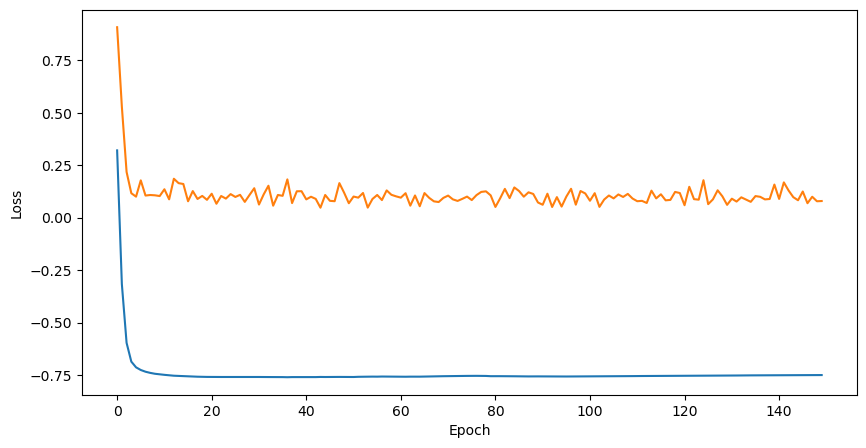

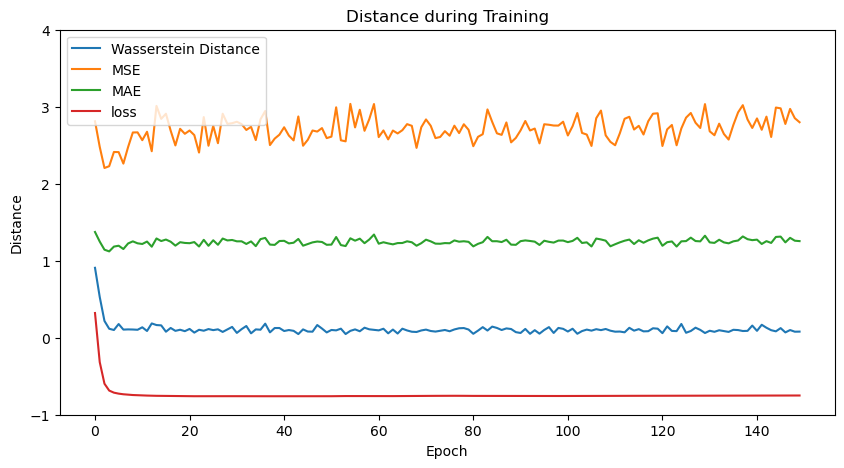

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="loss")
plt.plot(wasserstein_vals, label="Wasserstein Distance")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.ylim(0, 2)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(wasserstein_vals, label="Wasserstein Distance")
plt.plot(mse_vals, label="MSE")
plt.plot(mae_vals, label="MAE")
plt.plot(loss_history, label="loss")
plt.xlabel("Epoch")
plt.ylabel("Distance")
plt.title("Distance during Training")
plt.ylim(-1,4)
plt.legend()
plt.show()

### **3.5 Sampling from the Trained Flow Model**

Once training is complete, we generate new samples by drawing from the base uniform distribution and applying the inverse flow transformation.


In [60]:

# =============================================================================
# 5. Generazione di Campioni e Inversa della Normalizzazione
# =============================================================================
sample_size=100000
model.eval()
with torch.no_grad():
    # Campiona dalla base
    start=time.perf_counter()
    z_samples = torch.randn(sample_size)
    x_samples_norm, _ = model.inverse(z_samples)
    # Inverse normalization: riportiamo i campioni nella scala originale
    x_samples = x_samples_norm * (data_max - data_min) + data_min
    stop=time.perf_counter()
    x_samples = x_samples.numpy()
    GeneratorTimer=(stop-start)/sample_size


In [61]:
print(f"Time for generating a data: {GeneratorTimer:.2e}s")

Time for generating a data: 8.87e-08s


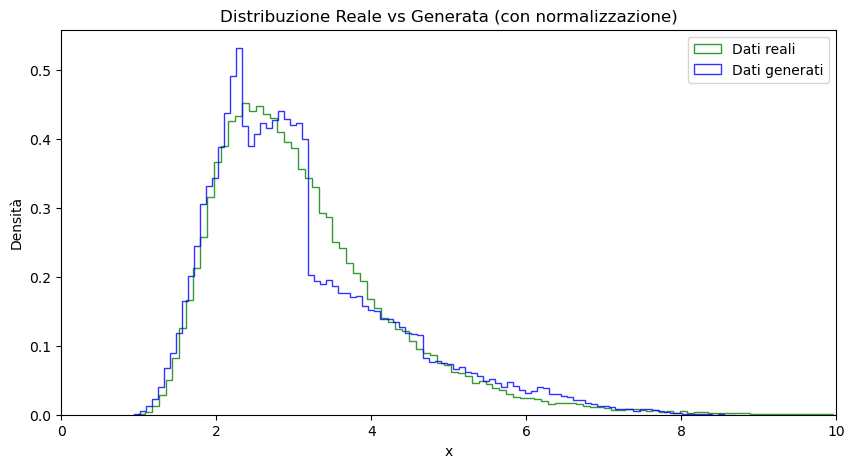

In [79]:

plt.figure(figsize=(10, 5))
plt.hist(data, bins=100, density=True, alpha=0.8, label='Dati reali', histtype='step', color="green")
plt.hist(x_samples, bins=100, density=True, alpha=0.8, label='Dati generati', histtype='step', color="blue")
plt.legend()
plt.xlabel("x")
plt.ylabel("Densità")
plt.title("Distribuzione Reale vs Generata (con normalizzazione)")
plt.xlim(0, 10)
plt.show()


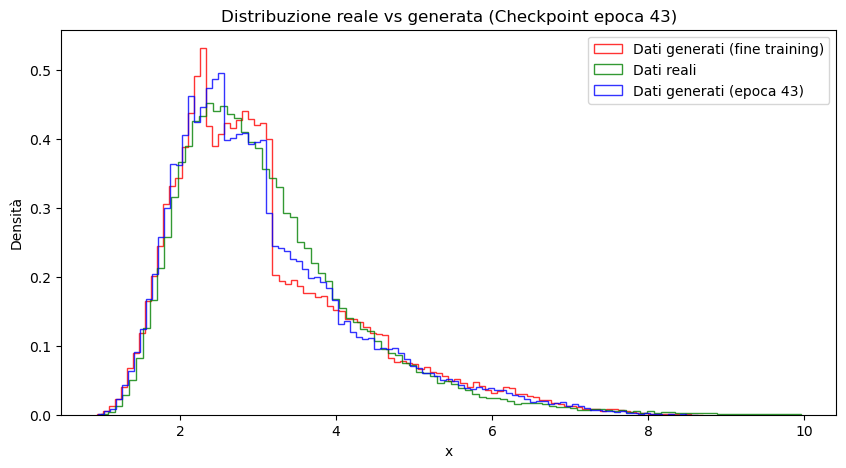

In [114]:
# Istanziamo il modello con la stessa architettura
model2 = FlowModel(num_layers=1, num_bins=40, left=0.0, right=1.0, bottom=-4.0, top=6.0)

# Carico i pesi salvati all'epoca desiderata
#epoch_saved = 16
checkpoint_path = f"Model/model_epoch_{epoch_saved}.pth"
model2.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model2.eval()

# Uso il modello per la generazione o la valutazione
with torch.no_grad():
    z_samples = torch.randn(100000)
    x_samples2, _ = model2.inverse(z_samples)
    x_samples2 = x_samples2 * (data_max - data_min) + data_min
    x_samples2 = x_samples2.numpy()

plt.figure(figsize=(10,5))
plt.hist(x_samples, bins=100, density=True, alpha=0.8, label='Dati generati (fine training)', histtype='step', color="red")
plt.hist(data, bins=100, density=True, alpha=0.8, label='Dati reali', histtype='step', color="green")
plt.hist(x_samples2, bins=100, density=True, alpha=0.8, label=f'Dati generati (epoca {epoch_saved})', histtype='step', color="blue")
plt.legend()
plt.xlabel("x")
plt.ylabel("Densità")
plt.title(f"Distribuzione reale vs generata (Checkpoint epoca {epoch_saved})")
plt.show()

In [1]:
print(mse_vals[149])
print(mse_vals[epoch_saved])

NameError: name 'mse_vals' is not defined

In [ ]:
print(mae_vals[149])
print(mae_vals[epoch_saved])

In [ ]:
print(wasserstein_vals[149])
print(wasserstein_vals[epoch_saved]) 